In [2]:
import pymc3 as pm
import theano
import theano.tensor as tt

import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')

In [2]:
# df = pd.read_csv('weekly_dmd.csv')
df = pd.read_csv('weekly_dmd_new.csv')
df['date'] = pd.to_datetime(df.date).apply(lambda x: x.date())
df = df.set_index(df.date)
df.index.rename('date_idx', inplace=True)
df.head(2)

,zone_id,date,total_demand_new,total_demand_new_lag1,total_demand_new_lag2,total_demand_new_lag3,total_demand_new_lag-1,total_demand_new_lag-2,total_demand_new_lag-3,smoothed_total_demand,year,total_demand_new_lag4,t4w_total_demand,month,week,day,t4w_total_demand_lag2,szn_factor
date_idx,,,,,,,,,,,,,,,,,,
2017-07-10,1,2017-07-10,2156.459303,NaN,NaN,NaN,2110.494687,2194.632691,2186.039578,NaN,2017,NaN,NaN,7,28,10,NaN,NaN
2017-07-10,597,2017-07-10,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,2017,NaN,NaN,7,28,10,NaN,NaN


In [3]:
df.date.max()

datetime.date(2021, 7, 5)

In [4]:
covid_start_idx = date(2020,2,17)

df_prep = df.loc[(df.date < covid_start_idx)
                | (df.date >= covid_start_idx + timedelta(weeks=52))].sort_values('date')

df_prep['y_obs'] = df_prep.total_demand_new
# df_prep['y_obs'] = df_prep.smoothed_total_demand
df_prep['covid_start_m1'] = df_prep.date.apply(lambda x: 1.0 if x == covid_start_idx - timedelta(weeks=1) else 0)

In [13]:
def fit_hw_model(zdf, initial_lvl_upper):
    szn_len = 52

    with pm.Model() as hw_model:
    #     initial_level = pm.Normal(f'initial_level', mu=3000, sigma=400)
#         initial_level = pm.Uniform(f'initial_level', lower=0, upper=5000)
        initial_level = pm.Uniform(f'initial_level', lower=0, upper=initial_lvl_upper)
        smoothing_level = pm.Uniform('smoothing_level', lower=0, upper=1)
#         smoothing_level = pm.Normal('smoothing_level', mu=0.5, sigma=0.5)

    #     initial_trend = pm.Normal(f'initial_trend', mu=0, sigma=100)
#         initial_trend = pm.Uniform(f'initial_trend', lower=-1000, upper=1000)
        initial_trend = pm.Uniform(f'initial_trend', lower=-initial_lvl_upper/2, upper=initial_lvl_upper/2)
        smoothing_trend = pm.Uniform('smoothing_trend', lower=0, upper=1)
    #     smoothing_trend = pm.Normal('smoothing_trend', mu=0.5, sigma=0.5)

        if len(zdf) < szn_len*2.5:
#         if len(zdf) < szn_len*2:
#             initial_szns = pm.Deterministic('initial_szns', 1.0, dims=(szn_len))
            initial_szns = tt.as_tensor_variable([1.0 for i in range(52)])
            smoothing_season = 0.0
#             smoothing_season = pm.Deterministic('smoothing_season', 1.0)
        else:
            initial_szns = pm.Normal('initial_szns', mu=1.0, sigma=0.2, shape=(szn_len))
        #     initial_szns = pm.Uniform('initial_szns', lower=0.7, upper=1.3, shape=(szn_len))
        #     smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1)
        #     smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1)
        #     smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1-smoothing_level)
            smoothing_season = pm.TruncatedNormal('smoothing_season', mu=0.2, sigma=0.5, lower=0, upper=0.8)
        #     smoothing_season = pm.Normal('smoothing_season', mu=0.5, sigma=0.5)

        ys = tt.as_tensor_variable(zdf['y_obs'])
        is_covid_start = tt.as_tensor_variable(zdf['covid_start_m1'])
    #     covid_level_change = pm.Normal('covid_level_change', mu=15000, sigma=2000)
        covid_level_change = pm.Uniform('covid_level_change', lower=0, upper=5000)
#         covid_level_change = pm.Normal('covid_level_change', mu=2000, sigma=1000)
    #     covid_level_change2 = pm.Normal('covid_level_change2', mu=20000, sigma=2000)
        covid_level_change2 = pm.Uniform('covid_level_change2', lower=0, upper=5000)
    #     covid_level_change2 = pm.Normal('covid_level_change2', mu=covid_level_change, sigma=1000)
    #     covid_level_change2 = pm.Normal('covid_level_change2', mu=covid_level_change, sigma=1000)

        def hw_component_wise(y, covid_start, prior_level, prior_trend, szn_m52):
            updated_szn = smoothing_season * y / (prior_level + prior_trend) + (1 - smoothing_season) * szn_m52


            next_level = smoothing_level * (y/szn_m52) + (1 - smoothing_level)*(prior_level + prior_trend) + covid_start*covid_level_change
            next_trend = smoothing_trend * (next_level - prior_level) + (1 - smoothing_trend)*prior_trend - covid_start*smoothing_trend*covid_level_change2


            return next_level, next_trend, updated_szn

        outputs, updates = theano.scan(hw_component_wise,
               sequences = [
                   ys[1:],
#                    ys[szn_len:],
                   is_covid_start[1:]
#                    is_covid_start[szn_len:]
        #            post_covid[szn_len:]
               ],
               outputs_info = [
                   dict(initial = initial_level, taps=None),
                   dict(initial = initial_trend, taps=None),
                   dict(initial = initial_szns, taps=[-szn_len])
               ], 
        #            non_sequences = 
               )


        levels = outputs[0]
        trends = outputs[1]
        seasons = outputs[2]


        levels_f = pm.math.concatenate([initial_level.reshape(1,1), levels[:-1]])
        trends_f = pm.math.concatenate([initial_trend.reshape(1,1), trends[:-1]])
        seasons_f = pm.math.concatenate([initial_szns, seasons[:-szn_len]])

        levels_and_trends = pm.math.stack([levels_f, trends_f])
        level_plus_trend = levels_and_trends.sum(axis=0)

        level_plus_trend_and_seasons = pm.math.stack([level_plus_trend, seasons_f])
        y_hats = level_plus_trend_and_seasons.prod(axis=0)

        sig = pm.HalfCauchy('sigma', beta=10)
#         y_like = pm.Normal('y_like', mu=y_hats, sigma=sig, observed=zdf.iloc[szn_len-1:-1, :]['y_obs_lag-1'])
        y_like = pm.Normal('y_like', mu=y_hats, sigma=sig, observed=zdf.iloc[:-1, :]['y_obs_lag-1'])
        
    map_estimate = pm.find_MAP(model=hw_model)
    
    return map_estimate, ys, is_covid_start

In [14]:
def predict(map_estimate, ys, is_covid_start, horizon):
    
    if 'initial_szns' in map_estimate:
        szn_estimates = tt.as_tensor_variable(map_estimate['initial_szns'])
        szn_smoother = map_estimate['smoothing_season']
    else:
        szn_estimates = tt.as_tensor_variable([1.0 for i in range(52)])
        szn_smoother = 0.0

    def hw_component_wise_final(y, covid_start, prior_level, prior_trend, szn_m52):
            updated_szn = szn_smoother * y / (prior_level + prior_trend) + (1 - szn_smoother) * szn_m52
#             updated_szn = map_estimate['smoothing_season'] * y / (prior_level + prior_trend) + (1 - map_estimate['smoothing_season']) * szn_m52


            next_level = map_estimate['smoothing_level'] * (y/szn_m52) + (1 - map_estimate['smoothing_level'])*(prior_level + prior_trend) + covid_start*map_estimate['covid_level_change']
            next_trend = map_estimate['smoothing_trend'] * (next_level - prior_level) + (1 - map_estimate['smoothing_trend'])*prior_trend - covid_start*map_estimate['smoothing_trend']*map_estimate['covid_level_change2']


            return next_level, next_trend, updated_szn

    outputs, updates = theano.scan(hw_component_wise_final,
               sequences = [
#                    ys[szn_len:],
                   ys[1:],
#                    is_covid_start[szn_len:]
                   is_covid_start[1:]
        #            post_covid[szn_len:]
               ],
               outputs_info = [
                   dict(initial = map_estimate['initial_level'], taps=None),
                   dict(initial = map_estimate['initial_trend'], taps=None),
                   dict(initial = szn_estimates, taps=[-szn_len])
#                    dict(initial = tt.as_tensor_variable(map_estimate['initial_szns']), taps=[-szn_len])
               ], 
        #            non_sequences = 
               )
    
    levels = outputs[0]
    trends = outputs[1]
    seasons = outputs[2]

    levels_f = pm.math.concatenate([map_estimate['initial_level'].reshape(1), levels[:-1]])
    trends_f = pm.math.concatenate([map_estimate['initial_trend'].reshape(1), trends[:-1]])
#     seasons_f = pm.math.concatenate([map_estimate['initial_szns'], seasons[:-szn_len]])
    seasons_f = pm.math.concatenate([szn_estimates, seasons[:-szn_len]])

    levels_and_trends = pm.math.stack([levels_f, trends_f])
    level_plus_trend = levels_and_trends.sum(axis=0)

    level_plus_trend_and_seasons = pm.math.stack([level_plus_trend, seasons_f])
    y_hats = level_plus_trend_and_seasons.prod(axis=0)
    
    corresponding_szn_idx = (horizon - szn_len) - 1
#     szn_estimate = seasons_f.get_test_value()[corresponding_szn_idx]
    szn_estimate = seasons.get_test_value()[corresponding_szn_idx]

#     pred = (levels_f.get_test_value()[-1] + horizon*trends_f.get_test_value()[-1])*szn_estimate
    pred = (levels.get_test_value()[-1] + horizon*trends.get_test_value()[-1])*szn_estimate
#     return pred, levels, trends, seasons, corresponding_szn_idx, szn_estimate, y_hats
    return pred, levels_f, trends_f, seasons_f, seasons, corresponding_szn_idx, szn_estimate, y_hats

In [9]:
latest_f_date = df_prep.date.max() + timedelta(weeks=1)
latest_f_date

datetime.date(2021, 7, 12)

In [10]:
zz = [18,  307,  438,  266,   90,  541,  272,  692,  475,  348,  273,
        178,  495,  694,  190,  707,  161,  521,  452,  489,  785,  942,
        972,  861,  973,  943,  975,  981,  974, 1002,  983, 1001,  839,
        714,    1,  783,  989,  787,   79,  945,  169,   37,  186,   76,
        620,  441,   32,  184,  477,  357,  530,  616,  167,  617,  437,
         38,  166, 1029,  428,  853,   43,   16,  982,  713,  988,  262,
        840,  144,  709,  181,  204,  440,  225,  245,  185,  104,  182,
        103,  439,   50,  946,  980,   27,  979,  183,  786,  131,   33,
        392,   87]

In [17]:
HORIZON = 2
szn_len = 52

In [18]:
### walk-forward validation

idx_outer = 1
pred_for_dates, zone_ids, preds, smoothing_levels, smoothing_trends, smoothing_seasons = [], [], [], [], [], []
for f_date in [latest_f_date]:
#     print(f'iter {idx_outer}/{len(test_dates2)}')
#     idx_outer += 1
    
    idx_inner = 1
    for z_id in zz:
        print(f'inner iter {idx_inner}')
        
        zdf = df_prep.loc[(df_prep.zone_id == z_id)
                            & (df_prep.date < f_date)
                            & (df_prep['y_obs'] > 0)
                           ]
    
        third_week = zdf.date.unique()[2]
        zdf = zdf.loc[zdf.date > third_week]
        
        
        pad_df = pd.DataFrame(columns = zdf.columns)
        pad_df.loc[0, 'zone_id'] = z_id
        zdf = pd.concat([pad_df, zdf])
        
        zdf['y_obs_lag-1'] = zdf.y_obs.shift(-1)
        initial_lvl_upper = zdf.head()['y_obs_lag-1'].max()
        
        map_estimate, ys, is_covid_start = fit_hw_model(zdf, initial_lvl_upper)
        pred, levels_f, trends_f, seasons_f, seasons, corresponding_szn_idx, szn_estimate, yhats = predict(map_estimate, ys, is_covid_start, HORIZON+1)
        
        pred_for_date = f_date + timedelta(weeks=HORIZON)
        
        pred_for_dates.append(pred_for_date)
        zone_ids.append(z_id)
        preds.append(pred)
        smoothing_levels.append(map_estimate['smoothing_level'])
        smoothing_trends.append(map_estimate['smoothing_trend'])
        if 'smoothing_season' in map_estimate:
            smoothing_seasons.append(map_estimate['smoothing_season'])
        else:
            smoothing_seasons.append(0.0)
        idx_inner += 1
        
res = pd.DataFrame({'pred_for_date': pred_for_dates,
                        'zone_id': zone_ids,
                        'pred': preds,
                        'smoothing_level': smoothing_levels,
                        'smoothing_trend': smoothing_trends,
                        'smoothing_season': smoothing_seasons})

res.pred_for_date = pd.to_datetime(res.pred_for_date)

inner iter 1


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 2


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 3


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 4


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 5


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 6


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 7


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 8


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 9


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 10


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 11


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 12


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 13


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 14


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 15


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 16


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 17


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 18


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 19


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 20


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 21


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 22


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 23


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 24


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 25


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 26


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 27


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 28


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 29


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 30


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 31


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 32


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 33


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 34


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 35


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 36


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 37


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 38


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 39


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 40


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 41


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 42


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 43


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 44


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 45


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 46


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 47


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 48


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 49


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 50


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 51


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 52


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 53


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 54


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 55


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 56


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 57


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 58


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 59


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 60


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 61


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 62


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 63


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 64


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 65


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 66


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 67


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 68


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 69


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 70


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 71


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 72


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 73


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 74


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 75


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 76


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 77


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 78


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 79


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 80


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 81


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 82


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 83


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 84


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 85


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 86


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 87


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 88


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 89


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 90


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 


In [ ]:
# [X] produce demand forecasts for f_date
    # [X] translate to DoW using existing method for DoW distribution
# [...] produce supply forecasts for f_date
    # [] pull historical melt rates and just use DES or shorter-term HW w/ daily seasonality for this
        # [-] can do some quick backtest here to see if we want to use the covid-handling version or out-of-box
    # [] use existing in-funnel estimate
    
# [] combine with ratios
    # [] compare results to what they would be with perfect forecasts

# [] finish implementing hierarchical version while existing forecasts are running
    # [] this will help get around the issues currently facing with not having enough data to get seasonal estimates in many places
        
# [] maybe should consider taking median (not mean) when grouping by week, since the DoW adjustments are generated relative to period medians
# [] could also calculate the relative DoW factors in here, since it's not much code, so that it's being done on the adjusted demand data (to account for holiday effects)

# [] look at correlation w/ recent and solve week LD, avail, TTA for old and new
# [] look at zones where old didnt have gap and LD was high (or other metrics low)
    # [] if we didn't have a gap, would we have a gap even with perfect forecast?
# [] vice versa for above

# [] shouldnt we actually be able to get accuracy improvement impacts from backtesting too?
    # [] ie, we can see what sage would have done w/ perfect forecasts

In [149]:
### translate to DoW using existing method for DoW distribution
# daily_dist = pd.read_csv('./daily_dist_f_date_7_19.csv')
daily_dist = pd.read_csv('./daily_dist_f_date_6_28.csv')

daily_dist['pred_for_date'] = daily_dist.pred_for_date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
daily_dist['forecast_date'] = daily_dist.forecast_date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())

daily_dist.head(2)

,zone_id,forecast_date,pred_for_date,total_supply_from_funnel,t7d_supply,median_dps,max_delivery_gap,forecasted_melt_old,forecasted_sessions_from_already_activated_shoppers_old,predicted_shopper_visits_old,ideal_supply_old,supply_deficit_old,ideal_ratio_old,delivery_gap_old
0,413,2021-06-28,2021-07-11,23.640279,671.0,1.157516,48.951892,0.881,591.213433,614.853712,475.871698,-138.982013,0.424652,0.0
1,413,2021-06-28,2021-07-12,26.153798,671.0,1.157516,42.033675,0.963,646.111591,672.265389,474.897647,-197.367742,0.499143,0.0


In [150]:
bt = pd.read_csv('./demand_fcast_fdate_06_28_21.csv')
# bt = pd.read_csv('./demand_fcast_fdate_07_19_21.csv')

bt['pred_for_week'] = bt.pred_for_date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
bt['forecast_date'] = bt.pred_for_week - timedelta(weeks=2)

bt.drop(columns=['pred_for_date'], inplace=True)
bt.head(2)

,zone_id,pred,smoothing_level,smoothing_trend,smoothing_season,pred_for_week,forecast_date
0,785,8581.905521,0.946619,7.154500e-07,0.0,2021-07-12,2021-06-28
1,942,7381.672431,0.999999,4.338273e-09,0.0,2021-07-12,2021-06-28


In [151]:
bt2 = bt.merge(daily_dist, on=['zone_id', 'forecast_date'])
bt2.shape

(630, 19)

In [152]:
bt2['dow'] = pd.to_datetime(bt2.pred_for_date).dt.day_name()

In [153]:
bt2.loc[bt2.zone_id == 1]

,zone_id,pred,smoothing_level,smoothing_trend,smoothing_season,pred_for_week,forecast_date,pred_for_date,total_supply_from_funnel,t7d_supply,median_dps,max_delivery_gap,forecasted_melt_old,forecasted_sessions_from_already_activated_shoppers_old,predicted_shopper_visits_old,ideal_supply_old,supply_deficit_old,ideal_ratio_old,delivery_gap_old,dow
98,1,3588.832185,0.708826,0.00003,2.756416e-07,2021-07-12,2021-06-28,2021-07-11,27.899361,1307.0,2.0,200.077491,0.827,1081.527618,1109.426979,581.941684,-527.485295,0.143467,0.0,Sunday
99,1,3588.832185,0.708826,0.00003,2.756416e-07,2021-07-12,2021-06-28,2021-07-12,30.615720,1307.0,2.0,206.182881,0.934,1220.864779,1251.480499,760.476501,-491.003999,0.176029,0.0,Monday
100,1,3588.832185,0.708826,0.00003,2.756416e-07,2021-07-12,2021-06-28,2021-07-13,37.564894,1307.0,2.0,178.188388,0.955,1248.556358,1286.121252,779.678870,-506.442382,0.204225,0.0,Tuesday
101,1,3588.832185,0.708826,0.00003,2.756416e-07,2021-07-12,2021-06-28,2021-07-14,31.227113,1307.0,2.0,172.638611,0.910,1188.988580,1220.215693,742.848354,-477.367339,0.203409,0.0,Wednesday
102,1,3588.832185,0.708826,0.00003,2.756416e-07,2021-07-12,2021-06-28,2021-07-15,34.777120,1307.0,2.0,173.280416,0.901,1177.809302,1212.586422,564.372271,-648.214151,0.156855,0.0,Thursday
103,1,3588.832185,0.708826,0.00003,2.756416e-07,2021-07-12,2021-06-28,2021-07-16,29.437036,1307.0,2.0,168.611443,0.885,1156.438304,1185.875340,590.666682,-595.208658,0.170426,0.0,Friday
104,1,3588.832185,0.708826,0.00003,2.756416e-07,2021-07-12,2021-06-28,2021-07-17,29.386506,1307.0,2.0,163.300595,0.824,1076.477665,1105.864171,572.646630,-533.217541,0.168259,0.0,Saturday


In [154]:
demand_dow_dist = pd.read_csv('./demand_dow_dist_f_date_6_28.csv')
# demand_dow_dist = pd.read_csv('./demand_dow_dist_f_date_7_19.csv')
demand_dow_dist.head(2)

,zone_id,dow,demand_relative_to_period_mean
0,1,Friday,0.926777
1,1,Monday,1.141183


In [155]:
bt2 = bt2.merge(demand_dow_dist, on=['zone_id', 'dow'])
bt2.shape

(630, 21)

In [156]:
bt2['demand_pred'] = bt2.pred * bt2.demand_relative_to_period_mean

In [157]:
# s = pd.read_csv('./supply_fcast_fdate_07_19_21.csv')
s = pd.read_csv('./supply_fcast_fdate_06_28_21.csv')

# s1 = pd.read_csv('./supply_fcast_fdate_07_19_21.csv')
# s2 = pd.read_csv('./supply_fcast_fdate_07_19_21_addition.csv')
# s = pd.concat([s1, s2])

s['pred_for_date'] = s.pred_for_date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
s['forecast_date'] = s.forecast_date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())

# s.drop(columns=['date'], inplace=True)
s.rename(columns={'pred': 'forecasted_melt'}, inplace=True)
s.head(2)

,zone_id,pred_for_date,forecasted_melt,horizon,forecast_date
0,785,2021-07-17,0.824605,19,2021-06-28
1,785,2021-07-13,0.947253,15,2021-06-28


In [158]:
bt3 = bt2.merge(s, on=['zone_id', 'forecast_date', 'pred_for_date'])
bt3.shape

(630, 24)

In [159]:
bt3['supply_pred'] = (bt3.forecasted_melt * bt3.t7d_supply) + bt3.total_supply_from_funnel
bt3['sd_ratio_pred'] = bt3.supply_pred / bt3.demand_pred

In [79]:
ideal_ratios = pd.read_clipboard()

In [80]:
ideal_ratios['ideal_ratio'] = ideal_ratios.weekday_ratio

In [160]:
ideal_ratios.head(2)

,zone_id,weekday_ratio,weekend_ratio,notes,ideal_ratio
0,1,0.35,0.4,NaN,0.35
1,16,0.70,0.7,NaN,0.70


In [142]:
# ideal_ratios = pd.read_csv('./ideal_ratio_2021-04-27.csv')
# ideal_ratios.rename(columns={'ratio': 'ideal_ratio'}, inplace=True)
# ideal_ratios.head(2)

,zone_id,dow,forecast_date,ideal_ratio,tta,Rk,Xsolution,Ysolution,a,b,data_level,data_pattern,remove_outlier,solution_method,solution_pattern
0,564,Monday,2021-04-27,0.738054,2.462841,"[array([ 0. , 0. , 27.3549374])]",[0.34602715 0.73805397 1.19982421],[25.30881355 2.46284061 2.90739889],45.474084,-58.276556,zone_dow,regular,False,break_point,valid_solution
1,564,Tuesday,2021-04-27,0.687835,2.540449,"[array([ 0. , 0. , 36.8017314])]",[0.30995669 0.68783454 1.23596226],[28.85405433 2.54044948 1.17318979],50.437955,-69.635214,zone_dow,regular,False,break_point,valid_solution


In [161]:
# bt3['dow'] = pd.to_datetime(bt3.pred_for_date).dt.day_name()
# bt4 = bt3.merge(ideal_ratios, on=['zone_id', 'dow'])

bt4 = bt3.merge(ideal_ratios, on='zone_id')
bt4.shape

(630, 30)

In [162]:
bt4.loc[bt4.zone_id == 1][['pred_for_date', 'dow', 'ideal_ratio', 'sd_ratio_pred']]

,pred_for_date,dow,ideal_ratio,sd_ratio_pred
98,2021-07-11,Sunday,0.35,0.284975
99,2021-07-12,Monday,0.35,0.311115
100,2021-07-13,Tuesday,0.35,0.367523
101,2021-07-14,Wednesday,0.35,0.362866
102,2021-07-15,Thursday,0.35,0.351022
103,2021-07-16,Friday,0.35,0.353912
104,2021-07-17,Saturday,0.35,0.351571


In [163]:
bt4.loc[bt4.zone_id == 942][['pred_for_date', 'dow', 'ideal_ratio', 'sd_ratio_pred']]

,pred_for_date,dow,ideal_ratio,sd_ratio_pred
7,2021-07-11,Sunday,0.65,0.483063
8,2021-07-12,Monday,0.65,0.546461
9,2021-07-13,Tuesday,0.65,0.606672
10,2021-07-14,Wednesday,0.65,0.610460
11,2021-07-15,Thursday,0.65,0.596418
12,2021-07-16,Friday,0.65,0.561563
13,2021-07-17,Saturday,0.65,0.536276


In [121]:
bt4.loc[bt4.zone_id == 18][['pred_for_date', 'dow', 'ideal_ratio', 'sd_ratio_pred']]

,pred_for_date,dow,ideal_ratio,sd_ratio_pred
511,2021-07-11,Sunday,0.9,0.743129
512,2021-07-12,Monday,0.9,0.719200
513,2021-07-13,Tuesday,0.9,0.927988
514,2021-07-14,Wednesday,0.9,0.992602
515,2021-07-15,Thursday,0.9,0.992050
516,2021-07-16,Friday,0.9,0.986151
517,2021-07-17,Saturday,0.9,1.098058


In [164]:
bt4.loc[bt4.zone_id == 975][['pred_for_date', 'dow', 'ideal_ratio', 'sd_ratio_pred']]

,pred_for_date,dow,ideal_ratio,sd_ratio_pred
42,2021-07-11,Sunday,0.63,0.405775
43,2021-07-12,Monday,0.63,0.510670
44,2021-07-13,Tuesday,0.63,0.554006
45,2021-07-14,Wednesday,0.63,0.562111
46,2021-07-15,Thursday,0.63,0.532216
47,2021-07-16,Friday,0.63,0.500814
48,2021-07-17,Saturday,0.63,0.504232


In [165]:
bt4['ideal_supply'] = bt4.demand_pred * bt4.ideal_ratio
bt4['supply_deficit'] = bt4.ideal_supply - bt4.supply_pred
bt4['supply_deficit_non_neg'] = np.maximum(bt4.supply_deficit, 0)
bt4['delivery_gap_pre_cap'] = bt4.supply_deficit_non_neg * bt4.median_dps
bt4['delivery_gap'] = np.minimum(bt4.delivery_gap_pre_cap, bt4.max_delivery_gap)

In [166]:
bt4['gap_diff'] = bt4.delivery_gap - bt4.delivery_gap_old

In [167]:
bt4.sort_values('gap_diff')[['zone_id', 'pred_for_date', 'dow', 'gap_diff', 'delivery_gap', 'delivery_gap_old', 'ideal_supply', 'ideal_supply_old']].head(10)

,zone_id,pred_for_date,dow,gap_diff,delivery_gap,delivery_gap_old,ideal_supply,ideal_supply_old
91,714,2021-07-11,Sunday,-1325.955908,186.287377,1512.243285,2955.010868,3984.352367
126,79,2021-07-11,Sunday,-504.538466,170.507843,675.046309,1871.475439,2270.562351
196,87,2021-07-11,Sunday,-500.325148,0.000000,500.325148,1673.930260,2108.168675
441,167,2021-07-11,Sunday,-495.346406,315.035349,810.381755,966.421469,1280.896719
182,183,2021-07-11,Sunday,-483.116822,0.000000,483.116822,1320.280430,1698.157529
259,144,2021-07-11,Sunday,-462.036286,0.000000,462.036286,1516.347418,1929.200561
28,973,2021-07-11,Sunday,-333.541026,0.000000,333.541026,2759.342908,3266.700727
560,178,2021-07-11,Sunday,-289.339040,0.000000,289.339040,1588.785906,2139.411363
301,185,2021-07-11,Sunday,-278.344833,188.003279,466.348112,939.508470,1092.064851
273,181,2021-07-11,Sunday,-272.978425,141.935285,414.913710,1677.579966,1839.980702


In [168]:
bt4.sort_values('gap_diff')[['zone_id', 'pred_for_date', 'dow', 'gap_diff', 'delivery_gap', 'delivery_gap_old', 'ideal_supply', 'ideal_supply_old']].tail(10)

,zone_id,pred_for_date,dow,gap_diff,delivery_gap,delivery_gap_old,ideal_supply,ideal_supply_old
294,225,2021-07-11,Sunday,296.540350,296.540350,0.000000,1237.945803,750.702113
4,785,2021-07-15,Thursday,304.052097,304.052097,0.000000,5235.219177,4167.110950
467,38,2021-07-16,Friday,306.543928,330.251901,23.707972,916.941748,759.042478
337,103,2021-07-12,Monday,341.081301,341.081301,0.000000,1302.953339,1142.341071
11,942,2021-07-15,Thursday,351.618620,351.618620,0.000000,4536.549620,3340.080146
10,942,2021-07-14,Wednesday,351.818868,351.818868,0.000000,4550.830680,3420.160135
9,942,2021-07-13,Tuesday,353.459305,353.459305,0.000000,4718.489308,3822.399500
12,942,2021-07-16,Friday,353.557214,353.557214,0.000000,4605.369433,3651.852107
5,785,2021-07-16,Friday,420.219392,420.219392,0.000000,5327.731256,4491.643541
315,104,2021-07-11,Sunday,426.385707,495.195250,68.809543,991.137261,897.114468


In [169]:
bt4.loc[bt4.zone_id == 975][['pred_for_date', 'dow', 'gap_diff', 'delivery_gap', 'delivery_gap_old', 'max_delivery_gap', 'ideal_supply', 'ideal_supply_old', 'ideal_ratio', 'ideal_ratio_old']]

,pred_for_date,dow,gap_diff,delivery_gap,delivery_gap_old,max_delivery_gap,ideal_supply,ideal_supply_old,ideal_ratio,ideal_ratio_old
42,2021-07-11,Sunday,-2.501110e-11,276.219036,276.219036,276.219036,3223.795139,5309.977950,0.63,0.962538
43,2021-07-12,Monday,-2.999911e-10,253.726389,253.726389,253.726389,2911.350511,3346.823660,0.63,0.678473
44,2021-07-13,Tuesday,4.750120e-10,232.335325,232.335325,232.335325,2636.963663,2658.051891,0.63,0.557711
45,2021-07-14,Wednesday,2.180625e+02,218.062512,0.000000,218.062512,2545.876455,2306.043710,0.63,0.515223
46,2021-07-15,Thursday,2.199125e+02,219.912450,0.000000,219.912450,2597.567388,2269.975793,0.63,0.504443
47,2021-07-16,Friday,-2.499974e-10,237.632058,237.632058,237.632058,2735.617186,2550.927366,0.63,0.534695
48,2021-07-17,Saturday,0.000000e+00,239.794286,239.794286,239.794286,2700.451913,3021.110935,0.63,0.631651


In [170]:
bt4.loc[bt4.zone_id == 861][['pred_for_date', 'dow', 'gap_diff', 'delivery_gap', 'delivery_gap_old', 'max_delivery_gap', 'ideal_supply', 'ideal_supply_old', 'ideal_ratio', 'ideal_ratio_old']]

,pred_for_date,dow,gap_diff,delivery_gap,delivery_gap_old,max_delivery_gap,ideal_supply,ideal_supply_old,ideal_ratio,ideal_ratio_old
21,2021-07-11,Sunday,-2.750085e-10,330.036641,330.036641,330.036641,5546.003865,8480.108144,0.85,1.254758
22,2021-07-12,Monday,-4.996537e-11,319.084493,319.084493,319.084493,5381.607971,6921.108384,0.85,0.991122
23,2021-07-13,Tuesday,2.501110e-11,294.451220,294.451220,294.451220,4721.957812,5450.055875,0.85,0.863057
24,2021-07-14,Wednesday,0.000000e+00,276.410515,276.410515,276.410515,4519.126598,4730.967034,0.85,0.801516
25,2021-07-15,Thursday,3.000196e-10,269.191022,269.191022,269.191022,4533.752553,4690.955392,0.85,0.800185
26,2021-07-16,Friday,-2.499974e-10,286.812029,286.812029,286.812029,4709.114653,5099.824726,0.85,0.838013
27,2021-07-17,Saturday,4.000071e-10,271.703538,271.703538,271.703538,4452.579155,5406.057217,0.85,0.908944


#### Comparing to old:

(0.0, 500.0)

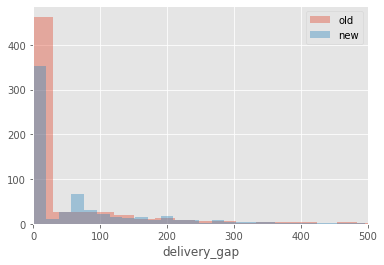

In [137]:
ax = sns.distplot(bt4.delivery_gap_old, label='old', kde=False)
sns.distplot(bt4.delivery_gap, ax=ax, label='new', kde=False)
ax.legend()
ax.set_xlim(0,500)

In [135]:
bt4[['delivery_gap_old', 'delivery_gap']].sum()

delivery_gap_old    29422.209957
delivery_gap        37848.635279
dtype: float64

/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


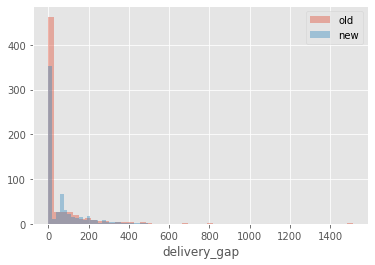

In [136]:
ax = sns.distplot(bt4.delivery_gap_old, label='old', kde=False)
sns.distplot(bt4.delivery_gap, ax=ax, label='new', kde=False)
ax.legend()

<AxesSubplot:xlabel='dow', ylabel='delivery_gap_old'>

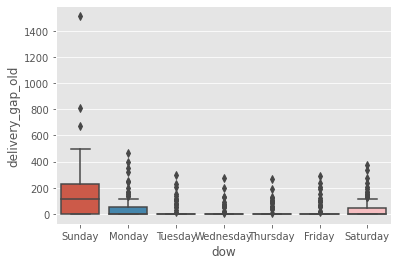

In [138]:
sns.boxplot(x='dow', y='delivery_gap_old', data=bt4)

<AxesSubplot:xlabel='dow', ylabel='delivery_gap'>

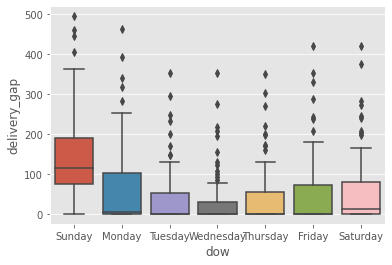

In [139]:
sns.boxplot(x='dow', y='delivery_gap', data=bt4)

/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


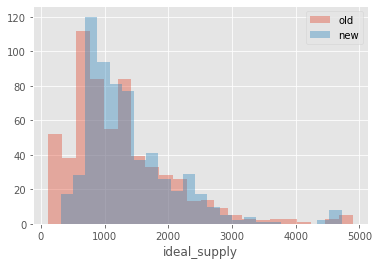

In [140]:
ax = sns.distplot(bt4.loc[bt4.ideal_supply_old < 5000].ideal_supply_old, label='old', kde=False)
sns.distplot(bt4.loc[bt4.ideal_supply < 5000].ideal_supply, label='new', kde=False)
ax.legend()

<AxesSubplot:xlabel='dow', ylabel='ideal_supply_old'>

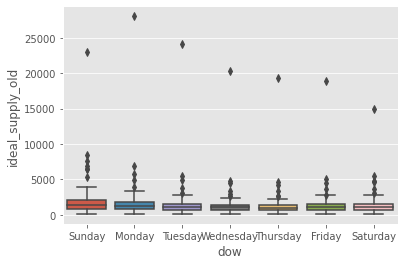

In [141]:
sns.boxplot(x='dow', y='ideal_supply_old', data=bt4)

(0.0, 10000.0)

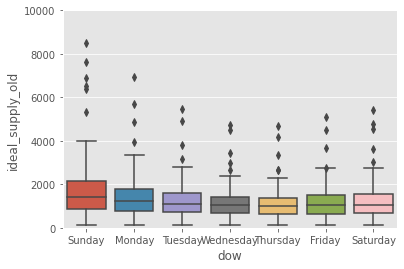

In [142]:
ax = sns.boxplot(x='dow', y='ideal_supply_old', data=bt4)
ax.set_ylim(0,10000)

<AxesSubplot:xlabel='dow', ylabel='ideal_supply'>

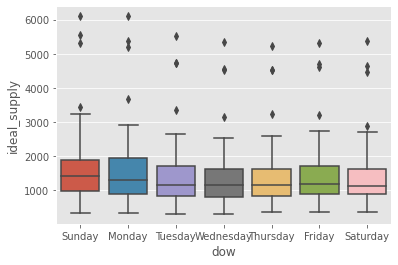

In [143]:
sns.boxplot(x='dow', y='ideal_supply', data=bt4)

In [145]:
COLUMNS = ['zone_id', 'pred_for_date', 'forecast_date', 'horizon',
               'forecast_span', 'min_horizon', 'delivery_gap',
               'version', 'manual_adjustment', 'active', 'created_at', 'data']

bt4['created_at'] = datetime.utcnow()
bt4['min_horizon'] = 13
bt4['forecast_span'] = 7
bt4['manual_adjustment'] = None
bt4['version'] = 'v1.2'
bt4['data'] = None
bt4['active'] = 'Y'

In [146]:
bt4.to_csv('./new_gaps_f_date_6_28.csv', index=None)
# bt4.to_csv('./new_gaps_f_date_7_19.csv', index=None)

### Backwards-Looking:

In [ ]:
# [] pull in actual daily demand and supply
# [] pull in metrics for the pred_for_dates
# [] look at how we'd shape up with perfect demand and supply forecasts

# [] look at % hitting max gap
# [] document some aggregate analysis and case studies 

# [] more test dates, repeat ^

# [] back to hierarchical forecast work
    # [] maybe can have it not run so long, since seemed to overfit

In [51]:
f_date

NameError: name 'f_date' is not defined

In [350]:
metrics = pd.read_csv('./metrics_fdate_04_26_21.csv')
metrics['date'] = metrics.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())

metrics.head(2)

,date,zone_id,total_demand,total_lost_demand,total_delivery_created,checkout_lost_demand,capacity_lost_demand,pre_checkout_lost_demand,supply_lost_demand,other_lost_demand,...,solvable_supply_ld_pct_post_inc,time_based_capacity_availability,actual_shopper_visits,actual_shopper_visits_full,avg_tta,p50_tta,p75_tta,p90_tta,dels_completed,dels_completed_by_new_shoppers
0,2021-05-10,520,435.603061,11.603061,424,5.857325,0.078712,5.745736,5.824448,5.778613,...,1.337100,100.0,255,298,14.468740,5.858333,17.358333,39.216667,458,2
1,2021-05-11,933,87.391945,3.391945,84,1.729079,0.014531,1.662866,1.677396,1.714548,...,1.919394,100.0,107,127,9.685446,5.450000,8.141666,16.533333,80,9


In [177]:
list(metrics)

['date',
 'zone_id',
 'total_demand',
 'total_lost_demand',
 'total_delivery_created',
 'checkout_lost_demand',
 'capacity_lost_demand',
 'pre_checkout_lost_demand',
 'supply_lost_demand',
 'other_lost_demand',
 'negative_capacity_supply_lost_demand',
 'solvable_supply_lost_demand_post_inc',
 'solvable_supply_lost_demand_pre_inc',
 'total_other_ld_pct',
 'total_ld_pct',
 'supply_ld_pct',
 'solvable_supply_ld_pct_pre_inc',
 'solvable_supply_ld_pct_post_inc',
 'time_based_capacity_availability',
 'actual_shopper_visits',
 'actual_shopper_visits_full',
 'avg_tta',
 'p50_tta',
 'p75_tta',
 'p90_tta']

In [351]:
bt5 = bt4.merge(metrics,
                left_on=['zone_id', 'pred_for_date'],
                right_on=['zone_id', 'date'])
bt5.shape

(630, 116)

In [181]:
bt5.loc[bt5.zone_id == 1][['pred_for_date', 'dow', 'supply_pred', 'actual_shopper_visits', 'demand_pred', 'total_demand']]

,pred_for_date,dow,supply_pred,actual_shopper_visits,demand_pred,total_demand
238,2021-05-09,Sunday,1209.305673,1188,4836.241396,4137.113552
239,2021-05-10,Monday,1342.589648,1383,4248.237004,4322.666790
240,2021-05-11,Tuesday,1354.594529,1436,3889.057458,3782.802797
241,2021-05-12,Wednesday,1349.259840,1417,3801.263897,3539.149618
242,2021-05-13,Thursday,1323.484894,1364,3672.532889,3423.184428
243,2021-05-14,Friday,1301.874061,1404,3720.868670,3576.268500
244,2021-05-15,Saturday,1255.475052,1298,3849.737671,3679.965251


In [273]:
bt5.loc[bt5.zone_id == 1][['pred_for_date', 'dow', 'supply_pred', 'actual_shopper_visits', 'demand_pred', 'total_demand']]

,pred_for_date,dow,supply_pred,actual_shopper_visits,demand_pred,total_demand
238,2021-05-09,Sunday,1209.305673,1188,4836.241396,4137.113552
239,2021-05-10,Monday,1342.589648,1383,4248.237004,4322.666790
240,2021-05-11,Tuesday,1354.594529,1436,3889.057458,3782.802797
241,2021-05-12,Wednesday,1349.259840,1417,3801.263897,3539.149618
242,2021-05-13,Thursday,1323.484894,1364,3672.532889,3423.184428
243,2021-05-14,Friday,1301.874061,1404,3720.868670,3576.268500
244,2021-05-15,Saturday,1255.475052,1298,3849.737671,3679.965251


#### Pre-Incentive Supply LD

<AxesSubplot:xlabel='delivery_gap', ylabel='solvable_supply_lost_demand_pre_inc'>

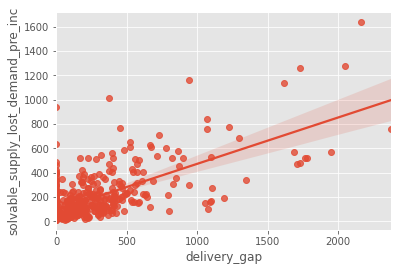

In [202]:
# before ideal ratio updates
sns.regplot(x='delivery_gap', y='solvable_supply_lost_demand_pre_inc', data=bt5)

<AxesSubplot:xlabel='delivery_gap', ylabel='solvable_supply_lost_demand_pre_inc'>

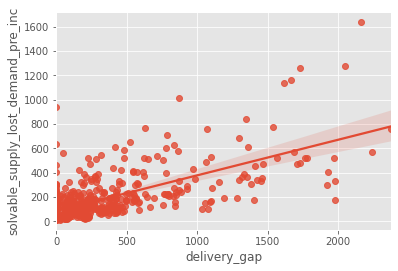

In [352]:
# after ideal ratio updates
sns.regplot(x='delivery_gap', y='solvable_supply_lost_demand_pre_inc', data=bt5)

<AxesSubplot:xlabel='delivery_gap_old', ylabel='solvable_supply_lost_demand_pre_inc'>

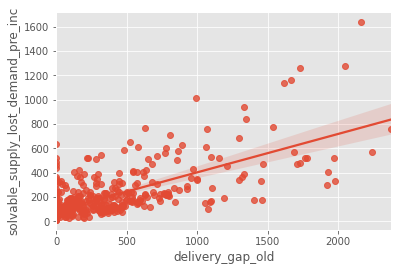

In [353]:
sns.regplot(x='delivery_gap_old', y='solvable_supply_lost_demand_pre_inc', data=bt5)

#### Mean TTA

<AxesSubplot:xlabel='delivery_gap', ylabel='avg_tta'>

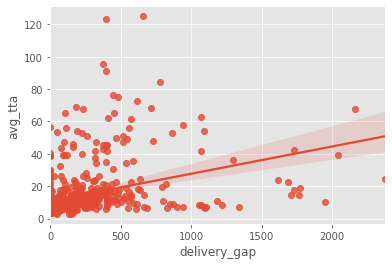

In [198]:
sns.regplot(x='delivery_gap', y='avg_tta', data=bt5)

<AxesSubplot:xlabel='delivery_gap', ylabel='avg_tta'>

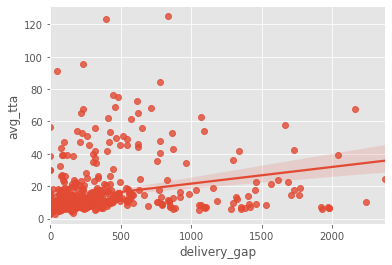

In [356]:
sns.regplot(x='delivery_gap', y='avg_tta', data=bt5)

<AxesSubplot:xlabel='delivery_gap_old', ylabel='avg_tta'>

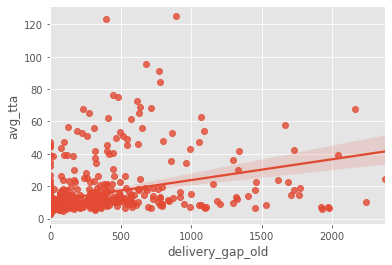

In [357]:
sns.regplot(x='delivery_gap_old', y='avg_tta', data=bt5)

#### Median TTA

<AxesSubplot:xlabel='delivery_gap', ylabel='p50_tta'>

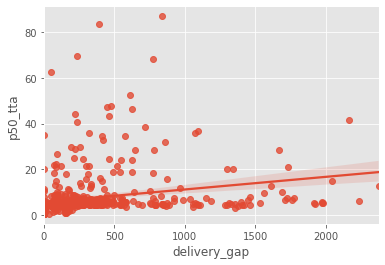

In [359]:
sns.regplot(x='delivery_gap', y='p50_tta', data=bt5)

<AxesSubplot:xlabel='delivery_gap_old', ylabel='p50_tta'>

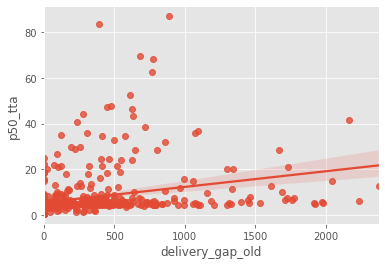

In [360]:
sns.regplot(x='delivery_gap_old', y='p50_tta', data=bt5)

#### Capacity Availability

<AxesSubplot:xlabel='delivery_gap', ylabel='time_based_capacity_availability'>

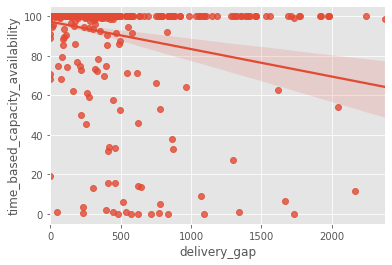

In [361]:
sns.regplot(x='delivery_gap', y='time_based_capacity_availability', data=bt5)

<AxesSubplot:xlabel='delivery_gap_old', ylabel='time_based_capacity_availability'>

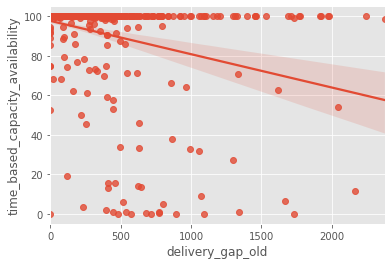

In [362]:
sns.regplot(x='delivery_gap_old', y='time_based_capacity_availability', data=bt5)

In [363]:
bt5['ideal_supply_p'] = bt5.total_demand_new * bt5.ideal_ratio
bt5['supply_deficit_p'] = bt5.ideal_supply - bt5.actual_shopper_visits
bt5['supply_deficit_non_neg_p'] = np.maximum(bt5.supply_deficit_p, 0)
bt5['delivery_gap_pre_cap_p'] = bt5.supply_deficit_non_neg_p * bt5.median_dps
bt5['delivery_gap_p'] = np.minimum(bt5.delivery_gap_pre_cap_p, bt5.max_delivery_gap)

<AxesSubplot:xlabel='demand_pred', ylabel='total_demand'>

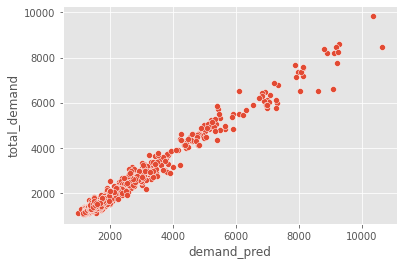

In [281]:
sns.scatterplot(x='demand_pred', y='total_demand', data=bt5)

<AxesSubplot:xlabel='demand_pred', ylabel='total_demand'>

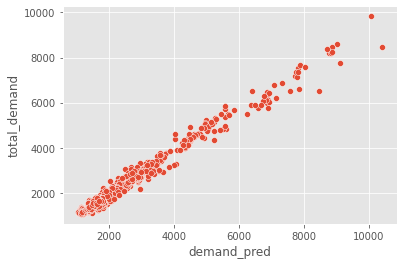

In [364]:
sns.scatterplot(x='demand_pred', y='total_demand', data=bt5)

<AxesSubplot:ylabel='Density'>

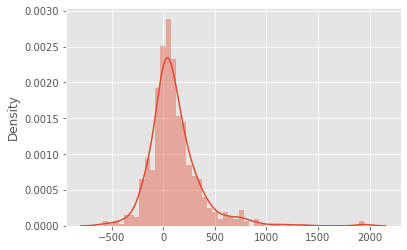

In [365]:
sns.distplot(bt5.demand_pred - bt5.total_demand)

<AxesSubplot:xlabel='supply_pred', ylabel='actual_shopper_visits'>

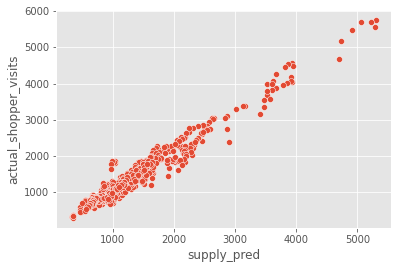

In [366]:
sns.scatterplot(x='supply_pred', y='actual_shopper_visits', data=bt5)

<AxesSubplot:ylabel='Density'>

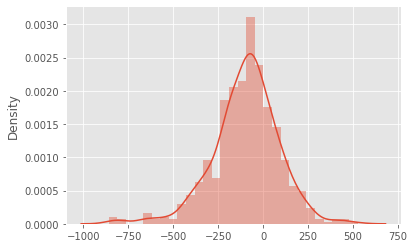

In [367]:
sns.distplot(bt5.supply_pred - bt5.actual_shopper_visits)

In [391]:
print(f'Old Gap: {round(bt5.delivery_gap_old.sum())}')
print(f'New Gap: {round(bt5.delivery_gap.sum())}')
# print(f'New Gap w/ Perfect Supply & Demand Forecasts: {round(bt5.delivery_gap_p.sum())}')

Old Gap: 156658
New Gap: 172367


In [369]:
print(f'Solvable Supply LD Pre-Incentives: {bt5.solvable_supply_lost_demand_pre_inc.sum()}')
print(f'Solvable Supply LD Post-Incentives: {bt5.solvable_supply_lost_demand_post_inc.sum()}')

Solvable Supply LD Pre-Incentives: 105075.900560592
Solvable Supply LD Post-Incentives: 42877.916304472004


<AxesSubplot:xlabel='dow', ylabel='delivery_gap'>

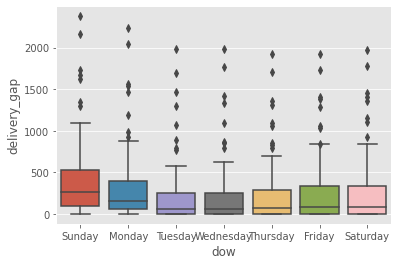

In [392]:
sns.boxplot(x='dow', y='delivery_gap', data=bt5)

<AxesSubplot:xlabel='dow', ylabel='delivery_gap_old'>

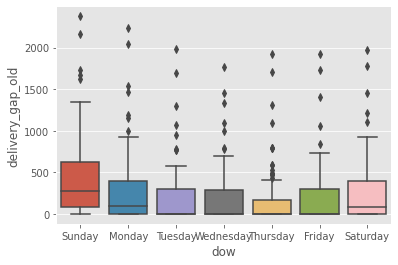

In [393]:
sns.boxplot(x='dow', y='delivery_gap_old', data=bt5)

<AxesSubplot:xlabel='dow', ylabel='p50_tta'>

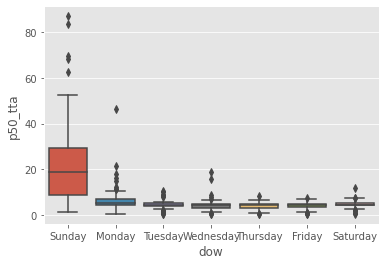

In [394]:
sns.boxplot(x='dow', y='p50_tta', data=bt5)

<AxesSubplot:xlabel='dow', ylabel='avg_tta'>

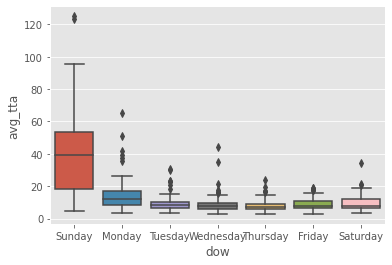

In [395]:
sns.boxplot(x='dow', y='avg_tta', data=bt5)

In [284]:
bt5.sort_values('gap_diff')[['zone_id', 'pred_for_date', 'dow', 'gap_diff', 'delivery_gap', 'delivery_gap_old', 'ideal_supply', 'ideal_supply_old']].head(10)

,zone_id,pred_for_date,dow,gap_diff,delivery_gap,delivery_gap_old,ideal_supply,ideal_supply_old
576,27,2021-05-11,Tuesday,-641.381709,123.458164,764.839874,1763.769053,15586.326229
579,27,2021-05-14,Friday,-632.146586,100.348665,732.495250,1712.270326,15428.736659
168,973,2021-05-09,Sunday,-585.231718,747.698898,1332.930616,3810.538061,4104.418800
577,27,2021-05-12,Wednesday,-551.789572,226.318586,778.108158,1846.704546,14613.214525
588,183,2021-05-09,Sunday,-493.125775,277.877019,771.002794,1394.051156,1599.396055
624,87,2021-05-10,Monday,-491.808364,36.148848,527.957212,1611.164928,1912.597790
629,87,2021-05-15,Saturday,-442.612544,0.000000,442.612544,1475.727584,1751.821471
575,27,2021-05-10,Monday,-431.236564,426.984699,858.221263,1945.605553,20633.508017
443,713,2021-05-11,Tuesday,-426.259929,144.400790,570.660719,1602.657990,1881.034475
623,87,2021-05-09,Sunday,-423.277058,256.459098,679.736156,1645.806117,1845.180000


In [370]:
zone_agg_gap_diffs = bt5.groupby('zone_id').gap_diff.sum().reset_index()

In [371]:
zone_agg_gap_diffs.sort_values('gap_diff').head()

,zone_id,gap_diff
3,27,-3393.595511
12,87,-2675.984487
62,713,-2012.324335
40,392,-1743.238761
77,973,-1332.930616


In [372]:
zone_agg_gap_diffs.sort_values('gap_diff').tail()

,zone_id,gap_diff
16,131,2013.641644
66,786,2193.121754
73,943,3398.811595
63,714,3534.299529
65,785,4862.198630


In [374]:
zone_agg_gap_diffs.loc[zone_agg_gap_diffs.gap_diff > 0].shape

(58, 2)

<AxesSubplot:xlabel='solvable_supply_ld_pct_pre_inc', ylabel='Density'>

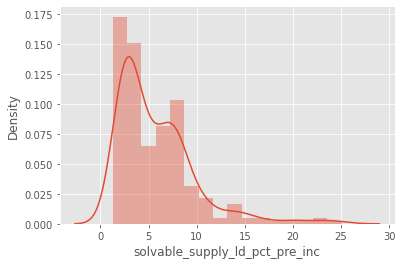

In [398]:
sns.distplot(bt5.loc[bt5.gap_diff > 0].solvable_supply_ld_pct_pre_inc)

<AxesSubplot:xlabel='solvable_supply_ld_pct_pre_inc', ylabel='Density'>

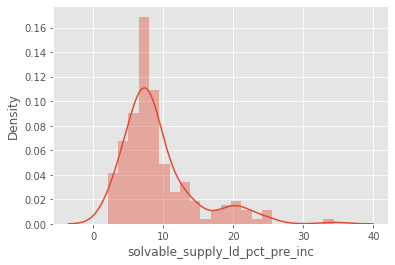

In [399]:
sns.distplot(bt5.loc[bt5.gap_diff < 0].solvable_supply_ld_pct_pre_inc)

<AxesSubplot:xlabel='p50_tta', ylabel='Density'>

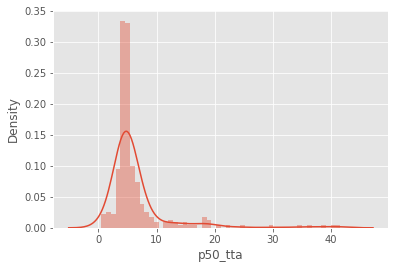

In [402]:
sns.distplot(bt5.loc[bt5.gap_diff > 0].p50_tta)

In [406]:
bt5.loc[bt5.gap_diff > 0].p50_tta.describe()

count    280.000000
mean       6.480982
std        5.777056
min        0.500000
25%        4.279166
50%        4.866667
75%        6.072917
max       41.625000
Name: p50_tta, dtype: float64

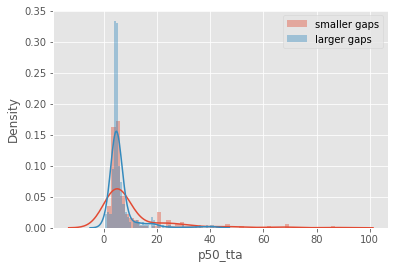

In [409]:
ax = sns.distplot(bt5.loc[bt5.gap_diff < 0].p50_tta, label='smaller gaps')
sns.distplot(bt5.loc[bt5.gap_diff > 0].p50_tta, label='larger gaps')
ax.legend(loc='best')

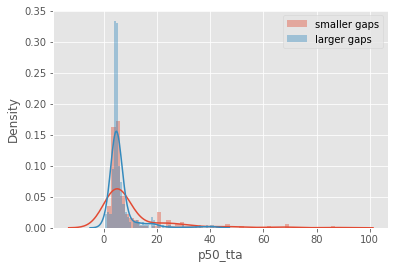

In [409]:
ax = sns.distplot(bt5.loc[bt5.gap_diff < 0].p50_tta, label='smaller gaps')
sns.distplot(bt5.loc[bt5.gap_diff > 0].p50_tta, label='larger gaps')
ax.legend(loc='best')

In [416]:
bt5['gap_diff'] = round(bt5.gap_diff)

<AxesSubplot:xlabel='gap_diff', ylabel='Density'>

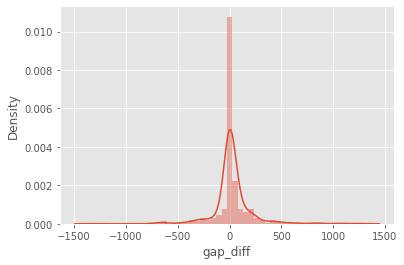

In [418]:
sns.distplot(bt5.gap_diff)

<AxesSubplot:xlabel='gap_diff', ylabel='p50_tta'>

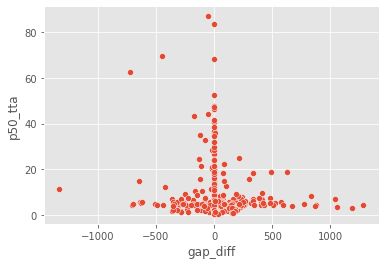

In [422]:
sns.scatterplot(x='gap_diff', y='p50_tta', data=bt5)

<AxesSubplot:xlabel='gap_diff', ylabel='avg_tta'>

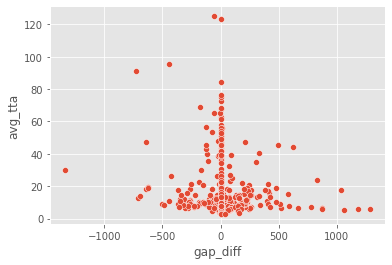

In [421]:
sns.scatterplot(x='gap_diff', y='avg_tta', data=bt5)

### Zone Case Studies

In [209]:
### Before ideal ratio updates

bt5.loc[bt5.zone_id == 942][[
    'pred_for_date', 'dow', 'delivery_gap', 'delivery_gap_old', 'max_delivery_gap',
    'solvable_supply_lost_demand_pre_inc', 'solvable_supply_lost_demand_post_inc',
    'solvable_supply_ld_pct_pre_inc', 'solvable_supply_ld_pct_post_inc',
    'avg_tta', 'p50_tta', 'time_based_capacity_availability',
    'ideal_supply', 'ideal_supply_old', 'ideal_ratio', 'ideal_ratio_old']]

,pred_for_date,dow,delivery_gap,delivery_gap_old,max_delivery_gap,solvable_supply_lost_demand_pre_inc,solvable_supply_lost_demand_post_inc,solvable_supply_ld_pct_pre_inc,solvable_supply_ld_pct_post_inc,avg_tta,p50_tta,time_based_capacity_availability,ideal_supply,ideal_supply_old,ideal_ratio,ideal_ratio_old
147,2021-05-09,Sunday,2376.624391,2376.624391,2376.624391,756.157306,187.894076,9.751183,2.423027,24.739088,12.616667,98.52,5126.082151,7631.333643,0.555673,0.831208
148,2021-05-10,Monday,1947.512272,2239.394356,2239.394356,569.166953,144.675462,6.786620,1.725078,10.144966,6.283333,100.00,4955.677095,7049.191093,0.562393,0.672035
149,2021-05-11,Tuesday,685.163875,1978.723577,1978.723577,334.784996,131.108096,4.438697,1.738277,6.406623,5.133333,100.00,4302.647668,5128.478100,0.529206,0.529899
150,2021-05-12,Wednesday,0.000000,1456.950416,1976.858470,176.718758,144.387731,2.458736,2.008906,6.287254,5.075000,100.00,3748.849744,4572.116593,0.461387,0.472716
151,2021-05-13,Thursday,395.073745,1926.685502,1926.685502,405.881905,136.146238,5.513472,1.849401,6.036762,4.833333,100.00,4024.345121,5543.084532,0.503931,0.583100
152,2021-05-14,Friday,941.726611,1919.506171,1919.506171,303.500388,102.957364,4.266649,1.447388,7.068168,5.333333,100.00,4166.458929,5010.706517,0.525579,0.530989
153,2021-05-15,Saturday,897.804809,1972.547796,1972.547796,522.349377,136.573106,7.090151,1.853786,7.220629,5.583333,100.00,3994.249202,6502.097574,0.494416,0.676125


In [377]:
### After ideal ratio updates

bt5.loc[bt5.zone_id == 942][[
    'pred_for_date', 'dow', 'delivery_gap', 'delivery_gap_old', 'max_delivery_gap',
#     'solvable_supply_lost_demand_pre_inc', 'solvable_supply_lost_demand_post_inc',
    'solvable_supply_ld_pct_pre_inc', 'solvable_supply_ld_pct_post_inc',
    'avg_tta', 'p50_tta', 'time_based_capacity_availability',
    'supply_pred', 'ideal_supply', 'ideal_supply_old', 'ideal_ratio', 'ideal_ratio_old',
    
    'demand_pred', 'total_demand',
    'supply_pred', 'actual_shopper_visits'
]]

,pred_for_date,dow,delivery_gap,delivery_gap_old,max_delivery_gap,solvable_supply_lost_demand_pre_inc,solvable_supply_lost_demand_post_inc,solvable_supply_ld_pct_pre_inc,solvable_supply_ld_pct_post_inc,avg_tta,...,time_based_capacity_availability,supply_pred,ideal_supply,ideal_supply_old,ideal_ratio,ideal_ratio_old,demand_pred,total_demand,supply_pred,actual_shopper_visits
147,2021-05-09,Sunday,2376.624391,2376.624391,2376.624391,756.157306,187.894076,9.751183,2.423027,24.739088,...,98.52,3531.384094,5927.641273,7631.333643,0.65,0.831208,9119.448113,7754.518378,3531.384094,3694
148,2021-05-10,Monday,2239.394356,2239.394356,2239.394356,569.166953,144.675462,6.786620,1.725078,10.144966,...,100.00,3928.154016,5665.377207,7049.191093,0.65,0.672035,8715.964933,8386.604332,3928.154016,4573
149,2021-05-11,Tuesday,1978.723577,1978.723577,1978.723577,334.784996,131.108096,4.438697,1.738277,6.406623,...,100.00,3941.149717,5090.979591,5128.478100,0.65,0.529899,7832.276293,7542.415920,3941.149717,4489
150,2021-05-12,Wednesday,1976.858470,1456.950416,1976.858470,176.718758,144.387731,2.458736,2.008906,6.287254,...,100.00,3867.859106,5019.328121,4572.116593,0.65,0.472716,7722.043264,7187.382278,3867.859106,4529
151,2021-05-13,Thursday,1926.685502,1926.685502,1926.685502,405.881905,136.146238,5.513472,1.849401,6.036762,...,100.00,3815.901047,5048.224232,5543.084532,0.65,0.583100,7766.498818,7361.638926,3815.901047,4454
152,2021-05-14,Friday,1919.506171,1919.506171,1919.506171,303.500388,102.957364,4.266649,1.447388,7.068168,...,100.00,3669.596423,5057.549650,5010.706517,0.65,0.530989,7780.845616,7113.320366,3669.596423,4260
153,2021-05-15,Saturday,1972.547796,1972.547796,1972.547796,522.349377,136.573106,7.090151,1.853786,7.220629,...,100.00,3520.560191,5088.645931,6502.097574,0.65,0.676125,7828.686047,7367.253263,3520.560191,3980


#### Smaller Gap Zones

In [379]:
# Underforecasted supply
bt5.loc[bt5.zone_id == 713][[
    'pred_for_date', 'dow', 'delivery_gap', 'delivery_gap_old', 'max_delivery_gap',
    'solvable_supply_lost_demand_pre_inc', 'solvable_supply_lost_demand_post_inc',
    'solvable_supply_ld_pct_pre_inc', 'solvable_supply_ld_pct_post_inc',
    'avg_tta', 'p50_tta', 'time_based_capacity_availability',
    'ideal_supply', 'ideal_supply_old', 'ideal_ratio', 'ideal_ratio_old',
    
    'demand_pred', 'total_demand',
    'supply_pred', 'actual_shopper_visits'

]]

,pred_for_date,dow,delivery_gap,delivery_gap_old,max_delivery_gap,solvable_supply_lost_demand_pre_inc,solvable_supply_lost_demand_post_inc,solvable_supply_ld_pct_pre_inc,solvable_supply_ld_pct_post_inc,avg_tta,p50_tta,time_based_capacity_availability,ideal_supply,ideal_supply_old,ideal_ratio,ideal_ratio_old,demand_pred,total_demand,supply_pred,actual_shopper_visits
441,2021-05-09,Sunday,782.942006,803.824093,803.824093,706.969467,551.240650,25.192310,19.643034,47.763922,28.500000,5.22,2014.657771,2709.571581,0.7,0.955244,2878.082530,2806.290734,1499.241872,1408
442,2021-05-10,Monday,326.574708,688.416941,688.416941,243.541262,38.647755,8.994447,1.427336,17.865592,7.183333,100.00,1754.849047,2178.924922,0.7,0.874442,2506.927209,2707.684642,1539.862757,1886
443,2021-05-11,Tuesday,65.782546,570.660719,570.660719,163.893023,32.091991,6.932203,1.357399,8.725431,4.716667,100.00,1550.903080,1881.034475,0.7,0.849096,2215.575829,2364.227013,1507.597995,1845
444,2021-05-12,Wednesday,121.220746,610.267456,610.267456,164.375363,29.696508,7.213581,1.303226,8.641516,4.400000,100.00,1541.551539,1898.120190,0.7,0.810037,2202.216484,2278.692941,1461.751120,1857
445,2021-05-13,Thursday,228.322027,529.437985,601.765967,170.505479,30.906623,7.448731,1.350192,6.737668,4.300000,100.00,1568.293246,1801.280153,0.7,0.776532,2240.418922,2289.053931,1417.987346,1843
446,2021-05-14,Friday,429.007837,411.451936,622.225926,76.499534,30.913241,3.099323,1.252427,9.755008,4.883333,100.00,1677.099319,1689.247419,0.7,0.731697,2395.856171,2468.266086,1394.680624,1763
447,2021-05-15,Saturday,375.283145,727.398219,727.398219,193.186795,31.048077,7.869913,1.264816,12.153950,5.716667,100.00,1686.005681,2182.164566,0.7,0.803892,2408.579545,2454.751372,1438.954306,1624


In [380]:
# most of these days had good p50 TTA -- maybe should use avg TTA?
bt5.loc[bt5.zone_id == 392][[
    'pred_for_date', 'dow', 'delivery_gap', 'delivery_gap_old', 'max_delivery_gap',
    'solvable_supply_lost_demand_pre_inc', 'solvable_supply_lost_demand_post_inc',
    'solvable_supply_ld_pct_pre_inc', 'solvable_supply_ld_pct_post_inc',
    'avg_tta', 'p50_tta', 'time_based_capacity_availability',
    'ideal_supply', 'ideal_supply_old', 'ideal_ratio', 'ideal_ratio_old',
    
    'demand_pred', 'total_demand',
    'supply_pred', 'actual_shopper_visits'

]]

,pred_for_date,dow,delivery_gap,delivery_gap_old,max_delivery_gap,solvable_supply_lost_demand_pre_inc,solvable_supply_lost_demand_post_inc,solvable_supply_ld_pct_pre_inc,solvable_supply_ld_pct_post_inc,avg_tta,p50_tta,time_based_capacity_availability,ideal_supply,ideal_supply_old,ideal_ratio,ideal_ratio_old,demand_pred,total_demand,supply_pred,actual_shopper_visits
616,2021-05-09,Sunday,413.852094,1058.337008,1058.337008,610.860677,409.942013,21.144042,14.189538,47.476030,14.783333,31.6,759.964996,1175.142453,0.23,0.296442,3304.195634,2889.044057,553.038949,475
617,2021-05-10,Monday,193.557773,282.628427,818.644901,313.956723,75.445556,9.761726,2.345797,14.456565,4.091666,100.0,725.882567,805.645164,0.23,0.269911,3156.011160,3216.200861,629.103680,699
618,2021-05-11,Tuesday,0.000000,225.357838,732.239628,195.900221,48.706735,7.793116,1.937605,7.699653,1.466667,100.0,620.693936,735.304319,0.23,0.278843,2698.669285,2513.759693,624.349081,649
619,2021-05-12,Wednesday,0.000000,281.313855,707.124476,187.300157,55.938940,7.955170,2.375886,7.704695,1.166667,100.0,581.189025,755.330038,0.23,0.281807,2526.908805,2354.445606,608.894664,644
620,2021-05-13,Thursday,3.588522,0.000000,697.397681,191.112073,50.537893,7.799038,2.062386,7.711007,1.233333,100.0,586.547092,588.893762,0.23,0.234883,2550.204747,2450.457069,584.752831,616
621,2021-05-14,Friday,3.942268,366.288709,714.030449,107.848744,43.006595,4.378215,1.745891,8.820868,1.800000,100.0,592.114302,788.000476,0.23,0.288391,2574.410007,2463.304102,590.143168,591
622,2021-05-15,Saturday,93.976349,238.229930,771.186144,218.552009,58.563912,8.364111,2.241275,9.547856,2.191667,100.0,607.731066,667.689417,0.23,0.241973,2642.308984,2612.973535,560.742892,534


In [381]:
# most of these days had good p50 TTA -- maybe should use avg TTA?
bt5.loc[bt5.zone_id == 90][[
    'pred_for_date', 'dow', 'delivery_gap', 'delivery_gap_old', 'max_delivery_gap',
    'solvable_supply_lost_demand_pre_inc', 'solvable_supply_lost_demand_post_inc',
    'solvable_supply_ld_pct_pre_inc', 'solvable_supply_ld_pct_post_inc',
    'avg_tta', 'p50_tta', 'time_based_capacity_availability',
    'ideal_supply', 'ideal_supply_old', 'ideal_ratio', 'ideal_ratio_old',
    
    'demand_pred', 'total_demand',
    'supply_pred', 'actual_shopper_visits'

]]

,pred_for_date,dow,delivery_gap,delivery_gap_old,max_delivery_gap,solvable_supply_lost_demand_pre_inc,solvable_supply_lost_demand_post_inc,solvable_supply_ld_pct_pre_inc,solvable_supply_ld_pct_post_inc,avg_tta,p50_tta,time_based_capacity_availability,ideal_supply,ideal_supply_old,ideal_ratio,ideal_ratio_old,demand_pred,total_demand,supply_pred,actual_shopper_visits
28,2021-05-09,Sunday,301.382997,414.681169,414.681169,278.411689,198.814294,19.557972,13.966384,39.893870,21.483334,13.33,1400.292741,1966.072780,1.0,1.300133,1400.292741,1423.520216,1081.340920,1122
29,2021-05-10,Monday,152.968589,406.169854,406.169854,132.986047,23.609268,7.952617,1.411843,21.482306,9.133333,100.00,1383.988700,1816.671634,1.0,1.167137,1383.988700,1672.229943,1222.102958,1486
30,2021-05-11,Tuesday,0.000000,166.877206,326.987102,89.108338,29.614465,6.432450,2.137775,29.757111,10.650000,91.08,1142.722964,1533.907341,1.0,1.120786,1142.722964,1385.293928,1245.756888,1362
31,2021-05-12,Wednesday,0.000000,99.211402,328.536518,57.299869,10.980654,4.523952,0.866947,12.011857,4.966667,100.00,1111.668532,1506.995813,1.0,1.109732,1111.668532,1266.588790,1277.875948,1449
32,2021-05-13,Thursday,0.000000,177.605913,325.227937,93.750280,15.558407,7.258391,1.204572,9.002090,4.466667,100.00,1120.408432,1534.243939,1.0,1.109191,1120.408432,1291.612435,1233.527518,1452
33,2021-05-14,Friday,0.000000,182.579513,321.013460,69.530296,16.001381,5.304665,1.220791,10.216908,4.525000,100.00,1147.977798,1534.158611,1.0,1.132155,1147.977798,1310.738654,1230.625698,1395
34,2021-05-15,Saturday,0.000000,258.904306,326.928301,94.491123,16.636750,7.520316,1.324078,11.678588,5.383333,100.00,1109.107615,1536.104387,1.0,1.132607,1109.107615,1256.478071,1231.142622,1280


In [382]:
# underforecast demand a bit
bt5.loc[bt5.zone_id == 87][[
    'pred_for_date', 'dow', 'delivery_gap', 'delivery_gap_old', 'max_delivery_gap',
#     'solvable_supply_lost_demand_pre_inc', 'solvable_supply_lost_demand_post_inc',
    'solvable_supply_ld_pct_pre_inc', 'solvable_supply_ld_pct_post_inc',
    'avg_tta', 'p50_tta', 'time_based_capacity_availability',
    'ideal_supply', 'ideal_supply_old', 'ideal_ratio', 'ideal_ratio_old', 'sd_ratio_pred',
    
    'demand_pred', 'total_demand',
    'supply_pred', 'actual_shopper_visits'

]]

,pred_for_date,dow,delivery_gap,delivery_gap_old,max_delivery_gap,solvable_supply_ld_pct_pre_inc,solvable_supply_ld_pct_post_inc,avg_tta,p50_tta,time_based_capacity_availability,ideal_supply,ideal_supply_old,ideal_ratio,ideal_ratio_old,sd_ratio_pred,demand_pred,total_demand,supply_pred,actual_shopper_visits
623,2021-05-09,Sunday,234.803205,679.736156,711.376993,18.133121,13.306401,95.617228,69.516666,0.37,1632.294521,1845.180000,0.6,0.6,0.546150,2720.490868,2622.828962,1485.795549,1306
624,2021-05-10,Monday,105.846390,527.957212,768.676021,8.098784,2.682911,26.604186,12.191667,100.00,1654.650783,1912.597790,0.6,0.6,0.576053,2757.751305,2963.296822,1588.610853,1778
625,2021-05-11,Tuesday,0.000000,342.431210,740.047362,8.613143,3.382861,14.645217,4.883333,100.00,1530.365242,1879.189903,0.6,0.6,0.644442,2550.608737,2738.436745,1643.720562,1835
626,2021-05-12,Wednesday,0.000000,318.884264,689.792950,11.139342,6.058164,8.507462,2.133333,100.00,1521.119199,1833.490791,0.6,0.6,0.641513,2535.198664,2739.009302,1626.362534,1737
627,2021-05-13,Thursday,0.000000,353.250008,697.535448,8.209559,3.081680,7.412338,1.983333,100.00,1584.124667,1865.592000,0.6,0.6,0.609274,2640.207778,2841.409362,1608.610545,1774
628,2021-05-14,Friday,113.337887,465.100574,711.488441,5.520481,2.395528,10.740199,3.958334,100.00,1624.755148,1883.088000,0.6,0.6,0.573886,2707.925247,2896.101429,1554.041105,1783
629,2021-05-15,Saturday,0.000000,442.612544,647.532999,8.970003,4.619090,10.885296,4.508333,100.00,1431.342721,1751.821471,0.6,0.6,0.632785,2385.571201,2668.397351,1509.554190,1619


In [318]:
# previously hitting guardrail every day. now gaps better aligned with solvable_supply_ld_pct_pre_inc
bt5.loc[bt5.zone_id == 27][[
    'pred_for_date', 'dow', 'delivery_gap', 'delivery_gap_old', 'max_delivery_gap',
#     'solvable_supply_lost_demand_pre_inc', 'solvable_supply_lost_demand_post_inc',
    'solvable_supply_ld_pct_pre_inc', 'solvable_supply_ld_pct_post_inc',
    'avg_tta', 'p50_tta', 'time_based_capacity_availability',
    'ideal_supply', 'ideal_supply_old', 'ideal_ratio', 'ideal_ratio_old', 'sd_ratio_pred',
    
    'demand_pred', 'total_demand',
    'supply_pred', 'actual_shopper_visits'

]]

,pred_for_date,dow,delivery_gap,delivery_gap_old,max_delivery_gap,solvable_supply_ld_pct_pre_inc,solvable_supply_ld_pct_post_inc,avg_tta,p50_tta,time_based_capacity_availability,ideal_supply,ideal_supply_old,ideal_ratio,ideal_ratio_old,sd_ratio_pred,demand_pred,total_demand,supply_pred,actual_shopper_visits
574,2021-05-09,Sunday,966.097267,966.097267,966.097267,14.614923,6.846450,34.101048,11.816667,64.31,2252.431966,18045.987250,0.6,4.657053,0.404609,3754.053277,2952.016177,1518.925032,1375
575,2021-05-10,Monday,426.984699,858.221263,858.221263,13.681583,7.316581,35.288691,10.608333,66.04,1945.605553,20633.508017,0.6,5.716207,0.520078,3242.675922,3683.021166,1686.444253,1817
576,2021-05-11,Tuesday,123.458164,764.839874,764.839874,8.232843,2.398458,18.518517,5.800000,100.00,1763.769053,15586.326229,0.6,4.763122,0.574509,2939.615088,2820.428999,1688.835271,1811
577,2021-05-12,Wednesday,226.318586,778.108158,778.108158,7.968669,2.869237,12.813522,4.433333,100.00,1846.704546,14613.214525,0.6,4.265187,0.555369,3077.840909,2751.439042,1709.338923,1800
578,2021-05-13,Thursday,410.395227,794.434373,794.434373,8.284259,3.087951,19.753163,5.133333,95.17,1897.284099,14209.403794,0.6,4.036762,0.521227,3162.140165,2575.061518,1648.191892,1620
579,2021-05-14,Friday,100.348665,732.495250,732.495250,6.420456,2.077559,18.739882,5.600000,100.00,1712.270326,15428.736659,0.6,4.856772,0.578657,2853.783876,2608.432136,1651.363013,1704
580,2021-05-15,Saturday,341.386913,732.545288,732.545288,8.994807,3.266029,14.004982,4.600000,100.00,1800.329942,12074.681410,0.6,3.615041,0.530944,3000.549904,2533.076770,1593.122807,1539


##### Larger Gaps

In [383]:
### Old version was likely misled by capacity staying on. Avg TTA's are high

bt5.loc[bt5.zone_id == 786][[
    'pred_for_date', 'dow', 'delivery_gap', 'delivery_gap_old', 'max_delivery_gap',
    'solvable_supply_lost_demand_pre_inc', 'solvable_supply_lost_demand_post_inc',
    'solvable_supply_ld_pct_pre_inc', 'solvable_supply_ld_pct_post_inc',
    'avg_tta', 'p50_tta', 'time_based_capacity_availability',
    
    'ideal_supply', 'ideal_supply_old', 'ideal_ratio', 'ideal_ratio_old',
    
    'demand_pred', 'total_demand'
#     'demand_dow_dist'
]]

,pred_for_date,dow,delivery_gap,delivery_gap_old,max_delivery_gap,solvable_supply_lost_demand_pre_inc,solvable_supply_lost_demand_post_inc,solvable_supply_ld_pct_pre_inc,solvable_supply_ld_pct_post_inc,avg_tta,p50_tta,time_based_capacity_availability,ideal_supply,ideal_supply_old,ideal_ratio,ideal_ratio_old,demand_pred,total_demand
595,2021-05-09,Sunday,546.741733,546.741733,546.741733,415.113204,190.466087,14.113083,6.475495,45.664420,24.033333,71.54,2188.920172,2146.039354,0.6,0.536861,3648.200286,2941.336133
596,2021-05-10,Monday,482.750693,68.949767,482.750693,82.323964,43.386461,2.510076,1.322863,15.877920,7.150000,100.00,1980.467768,1688.608761,0.6,0.468006,3300.779614,3279.740046
597,2021-05-11,Tuesday,314.731908,0.000000,429.757027,169.695554,21.334508,5.611354,0.705472,13.278823,5.416667,100.00,1767.214980,1406.667011,0.6,0.436287,2945.358300,3024.146274
598,2021-05-12,Wednesday,301.294030,0.000000,423.662481,67.402402,56.624456,2.135748,1.794233,34.711028,15.900000,93.31,1723.739206,1436.475715,0.6,0.441480,2872.898677,3155.914749
599,2021-05-13,Thursday,410.005679,0.000000,421.236027,67.052771,37.190794,2.532724,1.404774,17.229438,6.700000,100.00,1739.037990,1290.167142,0.6,0.402257,2898.396649,2647.456962
600,2021-05-14,Friday,422.093569,0.000000,422.093569,66.345299,33.575664,2.360875,1.194778,13.255088,5.333333,100.00,1770.923815,1225.625377,0.6,0.386340,2951.539692,2810.200084
601,2021-05-15,Saturday,457.761242,126.565599,457.761242,185.954368,41.217748,6.873585,1.523566,13.935922,6.116667,100.00,1766.679908,1529.352645,0.6,0.429602,2944.466514,2705.347673


In [386]:
### Old ideal ratios hit min value. Looks good to have larger gap here

bt5.loc[bt5.zone_id == 76][[
    'pred_for_date', 'dow', 'delivery_gap', 'delivery_gap_old', 'max_delivery_gap',
    'solvable_supply_lost_demand_pre_inc', 'solvable_supply_lost_demand_post_inc',
    'solvable_supply_ld_pct_pre_inc', 'solvable_supply_ld_pct_post_inc',
    'avg_tta', 'p50_tta', 'time_based_capacity_availability',
    
    'ideal_supply', 'ideal_supply_old', 'ideal_ratio', 'ideal_ratio_old',
    
    'demand_pred', 'total_demand',
    'supply_pred', 'actual_shopper_visits'
]]

,pred_for_date,dow,delivery_gap,delivery_gap_old,max_delivery_gap,solvable_supply_lost_demand_pre_inc,solvable_supply_lost_demand_post_inc,solvable_supply_ld_pct_pre_inc,solvable_supply_ld_pct_post_inc,avg_tta,p50_tta,time_based_capacity_availability,ideal_supply,ideal_supply_old,ideal_ratio,ideal_ratio_old,demand_pred,total_demand,supply_pred,actual_shopper_visits
301,2021-05-09,Sunday,493.283230,0.0,493.283230,178.829515,114.933667,12.424199,7.985028,45.183333,18.775000,52.59,1429.231322,209.202000,0.8,0.1,1786.539153,1439.364549,989.314527,876
302,2021-05-10,Monday,331.986972,0.0,441.856185,84.633230,22.457372,4.922536,1.306192,13.974369,6.800000,100.00,1372.318135,195.976904,0.8,0.1,1715.397669,1719.301541,1128.159710,1275
303,2021-05-11,Tuesday,120.326901,0.0,415.989848,63.737549,20.652949,4.172215,1.351928,9.579318,5.191667,100.00,1241.713258,187.226946,0.8,0.1,1552.141573,1527.666769,1153.219344,1217
304,2021-05-12,Wednesday,43.639129,0.0,410.129521,53.736299,19.382780,3.754644,1.354307,7.149434,4.583333,100.00,1184.938106,181.728495,0.8,0.1,1481.172632,1431.195470,1152.843891,1216
305,2021-05-13,Thursday,172.591602,0.0,405.889596,65.834925,25.413866,4.509003,1.740584,9.824746,4.933333,100.00,1221.649063,178.383161,0.8,0.1,1527.061329,1460.077321,1094.717294,1167
306,2021-05-14,Friday,202.205913,0.0,425.270538,63.752363,18.451634,4.131943,1.195894,14.964904,6.533333,100.00,1255.438004,183.899612,0.8,0.1,1569.297506,1542.914977,1106.726514,1181
307,2021-05-15,Saturday,162.823195,0.0,434.372512,90.384146,28.274257,6.262221,1.958968,14.511790,6.966667,100.00,1196.179358,187.357847,0.8,0.1,1495.224197,1443.324009,1076.431722,1099


In [387]:
### Overpred demand and under pred supply

bt5.loc[bt5.zone_id == 785][[
    'pred_for_date', 'dow', 'delivery_gap', 'delivery_gap_old', 'max_delivery_gap',
    'solvable_supply_lost_demand_pre_inc', 'solvable_supply_lost_demand_post_inc',
    'solvable_supply_ld_pct_pre_inc', 'solvable_supply_ld_pct_post_inc',
    'avg_tta', 'p50_tta', 'time_based_capacity_availability',
    
    'ideal_supply', 'ideal_supply_old', 'ideal_ratio', 'ideal_ratio_old',
    
    'demand_pred', 'total_demand',
    'supply_pred', 'actual_shopper_visits'
]]

,pred_for_date,dow,delivery_gap,delivery_gap_old,max_delivery_gap,solvable_supply_lost_demand_pre_inc,solvable_supply_lost_demand_post_inc,solvable_supply_ld_pct_pre_inc,solvable_supply_ld_pct_post_inc,avg_tta,p50_tta,time_based_capacity_availability,ideal_supply,ideal_supply_old,ideal_ratio,ideal_ratio_old,demand_pred,total_demand,supply_pred,actual_shopper_visits
140,2021-05-09,Sunday,1616.164829,1616.164829,1616.164829,1138.032261,339.393918,13.428194,4.004673,23.931414,12.683333,62.83,6767.994558,7721.678615,0.65,0.732985,10412.299320,8474.946233,4697.400374,4686
141,2021-05-10,Monday,1533.989728,1533.989728,1533.989728,772.931793,152.349525,7.862999,1.549845,8.479862,5.350000,100.00,6553.319014,6203.858671,0.65,0.612015,10082.029252,9829.986581,5288.831376,5577
142,2021-05-11,Tuesday,885.616835,11.096897,1358.118279,244.642397,130.937599,2.846619,1.523569,6.495303,4.383333,100.00,5854.202704,5169.527527,0.65,0.569457,9006.465699,8594.137989,5304.577517,5750
143,2021-05-12,Wednesday,870.065081,0.000000,1321.371607,334.340335,148.534893,3.951482,1.755495,5.930271,3.850000,100.00,5756.999274,4877.939557,0.65,0.541617,8856.921960,8461.137973,5217.025706,5688
144,2021-05-13,Thursday,1058.723900,0.000000,1301.879691,485.114229,148.468028,5.919729,1.811719,5.397016,3.433333,100.00,5713.419820,4897.387205,0.65,0.548084,8789.876646,8194.872829,5056.362164,5714
145,2021-05-14,Friday,1282.680894,0.000000,1282.680894,195.138649,120.495181,2.377841,1.468281,6.194059,4.366667,100.00,5743.771612,4515.007939,0.65,0.517636,8836.571711,8206.548035,4906.835003,5484
146,2021-05-15,Saturday,1356.921390,580.712573,1356.921390,612.072029,139.827159,7.404713,1.691598,7.153684,4.916667,100.00,5759.468404,5026.034603,0.65,0.555113,8860.720622,8265.979654,4733.319907,5164


In [388]:
### larger gaps look correct

bt5.loc[bt5.zone_id == 714][[
    'pred_for_date', 'dow', 'delivery_gap', 'delivery_gap_old', 'max_delivery_gap',
    'solvable_supply_lost_demand_pre_inc', 'solvable_supply_lost_demand_post_inc',
    'solvable_supply_ld_pct_pre_inc', 'solvable_supply_ld_pct_post_inc',
    'avg_tta', 'p50_tta', 'time_based_capacity_availability',
    
    'ideal_supply', 'ideal_supply_old', 'ideal_ratio', 'ideal_ratio_old',
    
    'demand_pred', 'total_demand',
    'supply_pred', 'actual_shopper_visits'
]]

,pred_for_date,dow,delivery_gap,delivery_gap_old,max_delivery_gap,solvable_supply_lost_demand_pre_inc,solvable_supply_lost_demand_post_inc,solvable_supply_ld_pct_pre_inc,solvable_supply_ld_pct_post_inc,avg_tta,p50_tta,time_based_capacity_availability,ideal_supply,ideal_supply_old,ideal_ratio,ideal_ratio_old,demand_pred,total_demand,supply_pred,actual_shopper_visits
231,2021-05-09,Sunday,1343.293845,1343.293845,1343.293845,842.653335,527.570463,19.434766,12.167766,41.768733,20.233333,0.75,3298.410217,4095.249592,0.63,0.761585,5235.571774,4335.803945,2143.450459,2092
232,2021-05-10,Monday,986.604285,998.290520,1152.868521,352.903560,63.963128,8.043440,1.457859,14.944269,6.550000,100.00,2833.608740,2838.153023,0.63,0.634765,4497.791652,4387.470753,2242.622833,2778
233,2021-05-11,Tuesday,579.268297,0.000000,1033.778226,310.370436,75.915341,7.057201,1.726162,15.339531,5.875000,91.73,2546.803207,2177.196907,0.63,0.515387,4042.544773,4397.925529,2199.815661,2638
234,2021-05-12,Wednesday,624.944538,0.000000,1030.115371,522.733088,514.448550,11.332412,11.152810,44.457344,18.750000,0.00,2538.435088,2125.618169,0.63,0.499928,4029.262045,4612.725699,2164.087013,2489
235,2021-05-13,Thursday,829.094952,0.000000,1010.278184,211.724339,94.123220,5.441241,2.418934,23.598321,8.233333,92.19,2584.045270,2151.518002,0.63,0.518971,4101.659158,3891.104018,2087.409040,2454
236,2021-05-14,Friday,1035.482809,0.000000,1035.482809,103.470751,47.286780,2.499909,1.142474,17.648716,7.016667,100.00,2686.210853,1966.322209,0.63,0.452345,4263.826751,4138.980505,2052.767324,2433
237,2021-05-15,Saturday,1152.420570,675.225401,1152.420570,325.580672,57.532891,7.615499,1.345724,18.838111,7.266667,100.00,2754.622260,2426.541558,0.63,0.515415,4372.416286,4275.237583,2054.107443,2304


In [389]:
### larger gaps look correct

bt5.loc[bt5.zone_id == 943][[
    'pred_for_date', 'dow', 'delivery_gap', 'delivery_gap_old', 'max_delivery_gap',
    'solvable_supply_lost_demand_pre_inc', 'solvable_supply_lost_demand_post_inc',
    'solvable_supply_ld_pct_pre_inc', 'solvable_supply_ld_pct_post_inc',
    'avg_tta', 'p50_tta', 'time_based_capacity_availability',
    
    'ideal_supply', 'ideal_supply_old', 'ideal_ratio', 'ideal_ratio_old',
    
    'demand_pred', 'total_demand',
    'supply_pred', 'actual_shopper_visits'
]]

,pred_for_date,dow,delivery_gap,delivery_gap_old,max_delivery_gap,solvable_supply_lost_demand_pre_inc,solvable_supply_lost_demand_post_inc,solvable_supply_ld_pct_pre_inc,solvable_supply_ld_pct_post_inc,avg_tta,p50_tta,time_based_capacity_availability,ideal_supply,ideal_supply_old,ideal_ratio,ideal_ratio_old,demand_pred,total_demand,supply_pred,actual_shopper_visits
175,2021-05-09,Sunday,1730.118766,1730.118766,1730.118766,1260.073421,806.892977,20.318153,13.010809,42.238866,20.983333,0.0,4282.688801,3862.944727,0.6,0.732817,7137.814668,6201.712361,2467.785804,2406
176,2021-05-10,Monday,1563.957324,1154.931167,1563.957324,519.547259,41.233617,7.968357,0.632405,21.539227,9.766667,100.0,3835.631268,3331.212151,0.6,0.648903,6392.718780,6520.130158,2653.582485,3057
177,2021-05-11,Tuesday,1462.418071,952.506035,1462.418071,357.570513,23.864376,6.513048,0.434683,8.960253,4.416667,100.0,3408.001434,3307.348640,0.6,0.662848,5680.002389,5490.063997,2619.390199,3038
178,2021-05-12,Wednesday,1421.430305,995.680030,1421.430305,344.395892,41.251278,7.157426,0.857307,7.359352,4.216667,100.0,3355.161725,3232.927638,0.6,0.650064,5591.936209,4811.727964,2634.400234,3027
179,2021-05-13,Thursday,1354.126302,168.075321,1354.126302,363.398795,40.146702,7.548662,0.833943,6.000845,3.200000,100.0,3301.093743,2923.342573,0.6,0.613217,5501.822906,4814.082036,2572.772694,2937
180,2021-05-14,Friday,1381.475247,713.417577,1381.475247,309.554202,33.032048,6.221208,0.663855,6.768094,4.116667,100.0,3344.526156,3030.786544,0.6,0.636342,5574.210261,4975.789363,2534.457648,2819
181,2021-05-15,Saturday,1408.401051,1208.386574,1408.401051,455.591227,49.790310,8.529504,0.932166,8.857251,4.533333,100.0,3347.948208,3190.866260,0.6,0.644121,5579.913681,5341.356494,2462.466939,2664


In [390]:
### larger gaps look correct -- high TTA's

bt5.loc[bt5.zone_id == 786][[
    'pred_for_date', 'dow', 'delivery_gap', 'delivery_gap_old', 'max_delivery_gap',
    'solvable_supply_lost_demand_pre_inc', 'solvable_supply_lost_demand_post_inc',
    'solvable_supply_ld_pct_pre_inc', 'solvable_supply_ld_pct_post_inc',
    'avg_tta', 'p50_tta', 'time_based_capacity_availability',
    
    'ideal_supply', 'ideal_supply_old', 'ideal_ratio', 'ideal_ratio_old',
    
    'demand_pred', 'total_demand',
    'supply_pred', 'actual_shopper_visits'
]]

,pred_for_date,dow,delivery_gap,delivery_gap_old,max_delivery_gap,solvable_supply_lost_demand_pre_inc,solvable_supply_lost_demand_post_inc,solvable_supply_ld_pct_pre_inc,solvable_supply_ld_pct_post_inc,avg_tta,p50_tta,time_based_capacity_availability,ideal_supply,ideal_supply_old,ideal_ratio,ideal_ratio_old,demand_pred,total_demand,supply_pred,actual_shopper_visits
595,2021-05-09,Sunday,546.741733,546.741733,546.741733,415.113204,190.466087,14.113083,6.475495,45.664420,24.033333,71.54,2188.920172,2146.039354,0.6,0.536861,3648.200286,2941.336133,1539.528742,1465
596,2021-05-10,Monday,482.750693,68.949767,482.750693,82.323964,43.386461,2.510076,1.322863,15.877920,7.150000,100.00,1980.467768,1688.608761,0.6,0.468006,3300.779614,3279.740046,1607.202869,1983
597,2021-05-11,Tuesday,314.731908,0.000000,429.757027,169.695554,21.334508,5.611354,0.705472,13.278823,5.416667,100.00,1767.214980,1406.667011,0.6,0.436287,2945.358300,3024.146274,1579.259732,1868
598,2021-05-12,Wednesday,301.294030,0.000000,423.662481,67.402402,56.624456,2.135748,1.794233,34.711028,15.900000,93.31,1723.739206,1436.475715,0.6,0.441480,2872.898677,3155.914749,1543.808946,1705
599,2021-05-13,Thursday,410.005679,0.000000,421.236027,67.052771,37.190794,2.532724,1.404774,17.229438,6.700000,100.00,1739.037990,1290.167142,0.6,0.402257,2898.396649,2647.456962,1494.186048,1768
600,2021-05-14,Friday,422.093569,0.000000,422.093569,66.345299,33.575664,2.360875,1.194778,13.255088,5.333333,100.00,1770.923815,1225.625377,0.6,0.386340,2951.539692,2810.200084,1512.540974,1688
601,2021-05-15,Saturday,457.761242,126.565599,457.761242,185.954368,41.217748,6.873585,1.523566,13.935922,6.116667,100.00,1766.679908,1529.352645,0.6,0.429602,2944.466514,2705.347673,1490.536045,1588
